# Titanic Project Ensemble Approach with WOE Encoding

In this Kaggle project I will attempt to correctly predict whom survived the Titanic shipwreck. I will attempt to use several Machine Learning techniques (ensemble of models) to see which model has the best accuracy. This ensemble approach is inspired by Kaggle contributor and youtuber [Ken Jee](https://www.kaggle.com/kenjee/titanic-project-example). Instead of extreme gradient boosting I included Ada Boost and Gradient Boosting classifiers. I used additional feaure engineering by transforming the variables Age and Fare into categorical variables using binning and applying an WOE (Weight of Evidence) encoder to every variable. The main reasoning behind this is treating the missing values within the Age column, avoiding outlier analysis and ensuring a degree of linearity. The usage of the WOE encoder strongly improved the accuracy of the models. The weak (even negative) correlation between variables (independence) substantiates the use of the WOE encoder. Because the "Women and children first" policy was enacted within the Titanic, reducing the granularity of the Age variable by binning it did not reduce in loss of information. At the end,I tried developing voting classifiers using different combinations of models and weights in order to find the model with the best performance.

## Overview¶
1.  Preliminary visualisations
2.  Data Cleaning
3.  Data Exploration
4.  Feature Engineering
5.  Data Preprocessing for Model
6.  Basic Model Building
7.  Model Tuning
8.  Ensemble Modle Building
9.  Results

First, I will import all the necessary packages and set my working directory.



In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('D:\Study\Datasets\Titanic dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

D:\Study\Datasets\Titanic dataset\base_submission.csv
D:\Study\Datasets\Titanic dataset\gender_submission.csv
D:\Study\Datasets\Titanic dataset\submission_vc_best.csv
D:\Study\Datasets\Titanic dataset\test.csv
D:\Study\Datasets\Titanic dataset\Titanic Project Ensemble Approach with WOE Encoding.ipynb
D:\Study\Datasets\Titanic dataset\Titanic Survival (Ensemble approach) .ipynb
D:\Study\Datasets\Titanic dataset\titanic.zip
D:\Study\Datasets\Titanic dataset\train.csv
D:\Study\Datasets\Titanic dataset\xgboost-1.2.0.tar.gz
D:\Study\Datasets\Titanic dataset\First submission\submission_rf.csv


Next, I will read the data downloaded from Kaggle and create the training and test datasets.

In [33]:
training = pd.read_csv(r'D:\Study\Datasets\Titanic dataset\train.csv')
test = pd.read_csv(r'D:\Study\Datasets\Titanic dataset\test.csv')

training['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN
all_data = pd.concat([training,test])

%matplotlib inline
all_data.columns

print(all_data.head(10))

    Age Cabin Embarked     Fare  \
0  22.0   NaN        S   7.2500   
1  38.0   C85        C  71.2833   
2  26.0   NaN        S   7.9250   
3  35.0  C123        S  53.1000   
4  35.0   NaN        S   8.0500   
5   NaN   NaN        Q   8.4583   
6  54.0   E46        S  51.8625   
7   2.0   NaN        S  21.0750   
8  27.0   NaN        S  11.1333   
9  14.0   NaN        C  30.0708   

                                                Name  Parch  PassengerId  \
0                            Braund, Mr. Owen Harris      0            1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...      0            2   
2                             Heikkinen, Miss. Laina      0            3   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)      0            4   
4                           Allen, Mr. William Henry      0            5   
5                                   Moran, Mr. James      0            6   
6                            McCarthy, Mr. Timothy J      0            7   
7     

C:\Users\i5\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


## Exploratory Data Analysis (EDA)
### 1) For numeric data
Made histograms to understand distributions
Corrplot
Pivot table comparing survival rate across numeric variables
### 2) For Categorical Data
Made bar charts to understand balance of classes
Made pivot tables to understand relationship with survival

In [4]:
#quick look at our data types & null counts 
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
train_test     891 non-null int64
dtypes: float64(2), int64(6), object(5)
memory usage: 73.2+ KB


We can see above that the Age variable has 177 missing values (19.9%), the Cabin variable has 687 missing values (77.1%) and the Embarked variable has 2 missing values (0.22%). Due to the very large number of missing values, the Cabin variable cannot be used and will be dropped in the subseuent sections. Unlike the Cabin variable, because the Embarked column only has 2 missing values, the missing observations can be dropped without a large impact on the estimates of the models to be fitted. Only the age variable is subject to imputation (in order to preserve information).

In [5]:
training_null=training[training["Embarked"].isna()]
print(training_null)

     PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  train_test  
61   female  38.0      0      0  113572  80.0   B28      NaN           1  
829  female  62.0      0      0  113572  80.0   B28      NaN           1  


In [6]:
# to better understand the numeric data, we want to use the .describe() method. This gives us an understanding of the central tendencies of the data 
training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.0
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.0
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.0
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.0
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.0
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.0
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.0
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.0


In [7]:
#quick way to separate numeric columns
training.describe().columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'train_test'],
      dtype='object')

In [8]:
# look at numeric and categorical values separately 
df_num = training[['Age','SibSp','Parch','Fare']]
df_num_test = test[['Age','SibSp','Parch','Fare']]
df_cat = training[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]

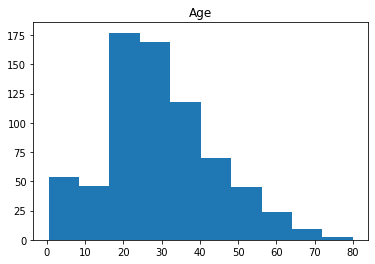

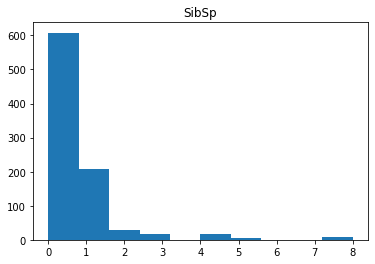

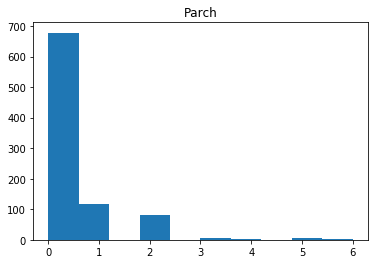

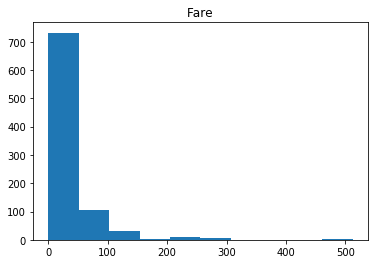

In [17]:
#distributions for all numeric variables 

for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

The variables above have rather non-normal distributions. Binning along with WOE encoding should solve this problem.

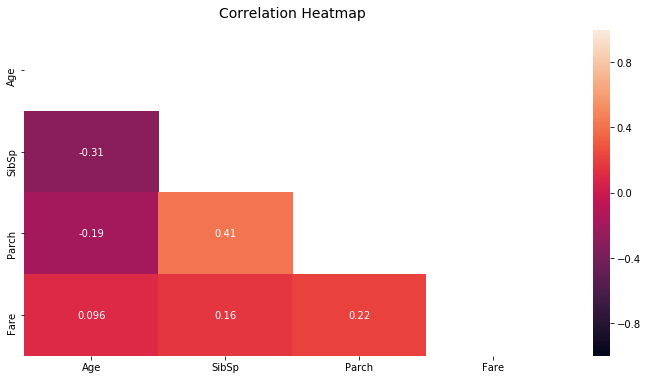

In [13]:
plt.figure(figsize=(12, 6))

mask = np.triu(np.ones_like(df_num.corr(), dtype=np.bool))
heatmap=sns.heatmap(df_num.corr(), mask=mask, vmin=-1, vmax=1,annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

In [18]:
# compare survival rate across Age, SibSp, Parch, and Fare 
pd.pivot_table(training, index = 'Survived', values = ['Age','SibSp','Parch','Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


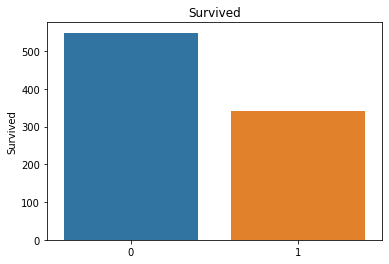

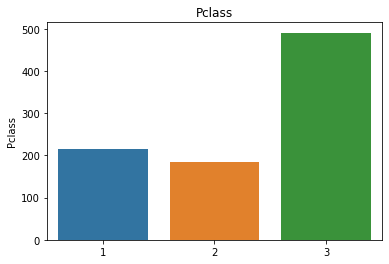

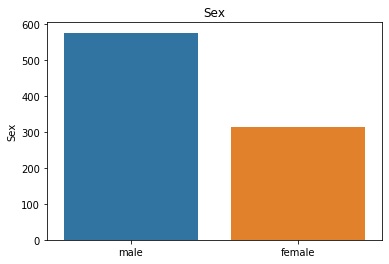

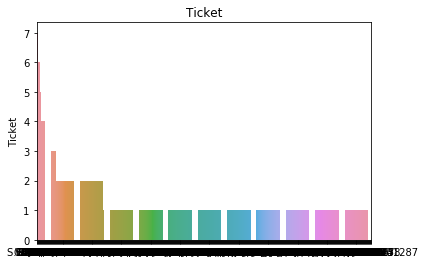

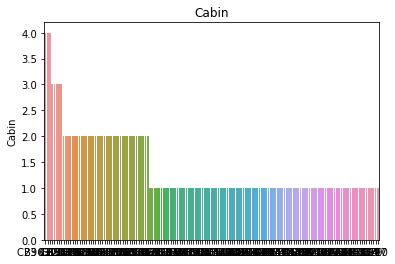

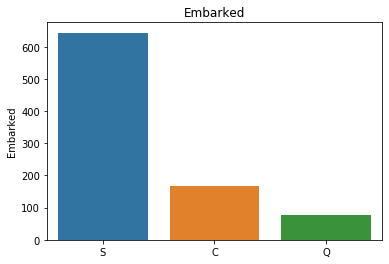

In [19]:
for i in df_cat.columns:
    sns.barplot(df_cat[i].value_counts().index,df_cat[i].value_counts()).set_title(i)
    plt.show()

For the Cabin and Ticket graphs, the values on the x axis are very crowded and, therefore difficult to interpret. Some feature engineering might be necessary.

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119



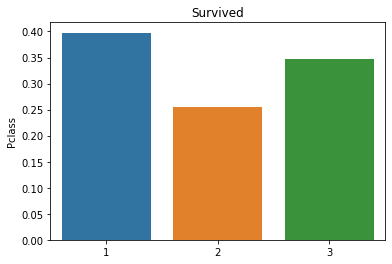

Sex       female  male
Survived              
0             81   468
1            233   109



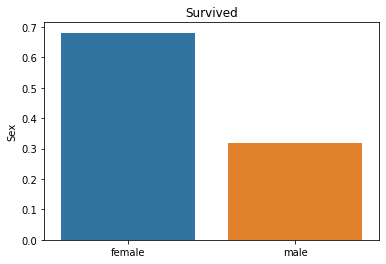

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217



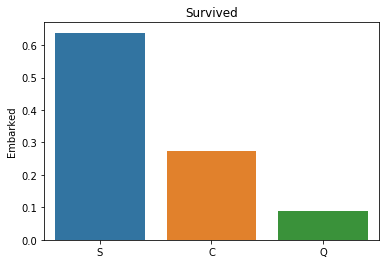

In [20]:
# Comparing survival and each of these categorical variables 
print(pd.pivot_table(training, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count'))
print()
sns.barplot(training.loc[training["Survived"]==1,"Pclass"].value_counts(normalize=True).index,training.loc[training["Survived"]==1,'Pclass'].value_counts(normalize=True)).set_title("Survived")
plt.show()
print(pd.pivot_table(training, index = 'Survived', columns = 'Sex', values = 'Ticket' ,aggfunc ='count'))
print()
sns.barplot(training.loc[training["Survived"]==1,"Sex"].value_counts(normalize=True).index,training.loc[training["Survived"]==1,"Sex"].value_counts(normalize=True)).set_title("Survived")
plt.show()
print(pd.pivot_table(training, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count'))
print()
sns.barplot(training.loc[training["Survived"]==1,"Embarked"].value_counts(normalize=True).index,training.loc[training["Survived"]==1,"Embarked"].value_counts(normalize=True)).set_title("Survived")
plt.show()

Feature Engineering
1.  Cabin - Simplify cabins (evaluated if cabin letter (cabin_adv) or the purchase of tickets across multiple cabins (cabin_multiple) impacted survival)¶
2.  Tickets - Do different ticket types impact survival rates?
3.  Does a person's title relate to survival rates?

In [21]:
df_cat.Cabin
training['cabin_multiple'] = training.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
# after looking at this, we may want to look at cabin by letter or by number. Let's create some categories for this 
# letters 
# multiple letters 
training['cabin_multiple'].value_counts()

0    687
1    180
2     16
3      6
4      2
Name: cabin_multiple, dtype: int64

In [22]:
pd.pivot_table(training, index = 'Survived', columns = 'cabin_multiple', values = 'Ticket' ,aggfunc ='count')

cabin_multiple,0,1,2,3,4
Survived,,,,,
0,481.0,58.0,7.0,3.0,NaN
1,206.0,122.0,9.0,3.0,2.0


In [23]:
#creates categories based on the cabin letter (n stands for null)
#in this case we will treat null values like it's own category

training['cabin_adv'] = training.Cabin.apply(lambda x: str(x)[0])

In [24]:
#comparing surivial rate by cabin
print(training.cabin_adv.value_counts())
pd.pivot_table(training,index='Survived',columns='cabin_adv', values = 'Name', aggfunc='count')

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: cabin_adv, dtype: int64


cabin_adv,A,B,C,D,E,F,G,T,n
Survived,,,,,,,,,
0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0,481.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,206.0


In [25]:
#understand ticket values better 
#numeric vs non numeric 
training['numeric_ticket'] = training.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
training['ticket_letters'] = training.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)

In [26]:
training['numeric_ticket'].value_counts()

1    661
0    230
Name: numeric_ticket, dtype: int64

In [27]:
#lets us view all rows in dataframe through scrolling. This is for convenience 
pd.set_option("max_rows", None)
training['ticket_letters'].value_counts()

0            665
pc            60
ca            41
a5            21
stono2        18
sotonoq       15
scparis       11
wc            10
a4             7
soc            6
fcc            5
c              5
wep            3
pp             3
sopp           3
swpp           2
ppp            2
scah           2
sotono2        2
as             1
sop            1
scahbasle      1
fc             1
casoton        1
sc             1
sca4           1
sp             1
fa             1
scow           1
Name: ticket_letters, dtype: int64

In [28]:
#difference in numeric vs non-numeric tickets in survival rate 
pd.pivot_table(training,index='Survived',columns='numeric_ticket', values = 'Ticket', aggfunc='count')

numeric_ticket,0,1
Survived,,
0,142,407
1,88,254


In [29]:
#feature engineering on person's title 
training.Name.head(50)
training['name_title'] = training.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
#mr., ms., master. etc

In [30]:
training['name_title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Don               1
the Countess      1
Mme               1
Jonkheer          1
Lady              1
Ms                1
Sir               1
Capt              1
Name: name_title, dtype: int64

## Data Preprocessing for Model¶
1.  Dropped null values from Embarked (only 2)
2.  Included only relevant variables (only  excluded name and passanger ID)
Variables: 'Pclass', 'Sex','Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'cabin_adv', 'cabin_multiple', 'numeric_ticket', 'name_title'

3. Transfomed continuous numeric variables into discrete categorical variables. 
4. Created a separate category for null values of the Age variable.
5. Used WOE encoder on all variables.


In [34]:
#create all categorical variables that we did above for both training and test sets 
all_data['cabin_multiple'] = all_data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['cabin_adv'] = all_data.Cabin.apply(lambda x: str(x)[0])
all_data['numeric_ticket'] = all_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
all_data['ticket_letters'] = all_data.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)
all_data['name_title'] = all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())


#impute values for continuous data 
#!pip install category_encoders
import category_encoders as ce
from pandas import DataFrame

#

all_data.loc[df_num['Age'] <= 14, 'Age_cat'] = 'Child' 
all_data.loc[(df_num['Age']>14) & (df_num['Age']<18), 'Age_cat'] = 'Teenager' 
all_data.loc[df_num['Age']>=18, 'Age_cat'] = 'Adult'
all_data.loc[df_num['Age'].isnull(), 'Age_cat'] = 'Missing'
all_data=all_data.drop(['Age'], axis = 1) 
all_data.loc[df_num['Fare'] <= 7.910400, 'Fare_cat'] = 'Quartile 1' 
all_data.loc[(df_num['Fare']>7.910400) & (df_num['Fare']<=14.454200), 'Fare_cat'] = 'Quartile 2'
all_data.loc[(df_num['Fare']>14.454200) & (df_num['Fare']<=31.000000), 'Fare_cat'] = 'Quartile 3'
all_data.loc[(df_num['Fare']>31.000000) & (df_num['Fare']<=512.329200), 'Fare_cat'] = 'Quartile 4'
all_data=all_data.drop(['Fare'], axis = 1) 



print(all_data['Age_cat'].value_counts())
print()
print(all_data['Fare_cat'].value_counts())

    
#X_train = all_data[all_data.train_test == 1].drop(['train_test'], axis =1)
#X_test = all_dummies[all_data.train_test == 0].drop(['train_test'], axis =1)


Adult       880
Missing     260
Child       114
Teenager     55
Name: Age_cat, dtype: int64

Quartile 2    335
Quartile 3    325
Quartile 4    325
Quartile 1    324
Name: Fare_cat, dtype: int64


In [35]:
#drop null 'embarked' rows. Only 2 instances of this in training and 0 in test 
all_data.dropna(subset=['Embarked'],inplace = True)

#drop 'name' column. 
all_data=all_data.drop(['Name'], axis = 1) 

X_train = all_data[all_data.train_test == 1].drop(['train_test'], axis =1)
X_test = all_data[all_data.train_test == 0].drop(['train_test'], axis =1)

In [36]:
columns = [col for col in X_train.columns if (col != 'PassengerId') & (col != 'Survived')]
woe_encoder = ce.WOEEncoder(cols=columns).fit(X_train[columns], X_train['Survived'])

# Encoding training data
woe_X_train = woe_encoder.transform(X_train[columns], X_train['Survived']).add_suffix('_woe')
X_train_woe_v0 = X_train.join(woe_X_train)

woe_encoded_cols = woe_X_train.columns

pd.set_option('display.max_columns',100)  

X_train_woe=X_train_woe_v0.filter(regex='_woe$',axis=1)#.join(X_train_woe_v0['Survived'])



# Encoding test data

woe_X_test = woe_encoder.transform(X_test[columns]).add_suffix('_woe')
X_test_woe_v0 = X_test.join(woe_X_test)
X_test_woe=X_test_woe_v0.filter(regex='_woe$',axis=1)#.join(X_test_woe_v0['Survived'])

print("WOE training data")
print(X_train_woe.head())
print()
print()
print("WOE test data")
print(X_test_woe.head())






WOE training data
   Cabin_woe  Embarked_woe  Parch_woe  Pclass_woe   Sex_woe  SibSp_woe  \
0  -0.368301     -0.197704  -0.176658   -0.657163 -0.973198   0.619344   
1   0.000000      0.689486  -0.176658    0.987750  1.516942   0.619344   
2  -0.368301     -0.197704  -0.176658   -0.657163  1.516942  -0.169703   
3   0.476924     -0.197704  -0.176658    0.987750  1.516942   0.619344   
4  -0.368301     -0.197704  -0.176658   -0.657163 -0.973198  -0.169703   

   Ticket_woe  cabin_multiple_woe  cabin_adv_woe  numeric_ticket_woe  \
0    0.000000           -0.368301      -0.368301            0.002716   
1    0.000000            1.195177       0.841567            0.002716   
2    0.000000           -0.368301      -0.368301            0.002716   
3    0.476924            1.195177       0.841567           -0.000954   
4    0.000000           -0.368301      -0.368301           -0.000954   

   ticket_letters_woe  name_title_woe  Age_cat_woe  Fare_cat_woe  
0           -1.420196       -1.196290

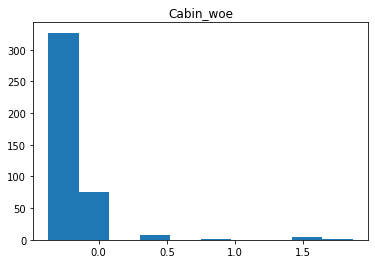

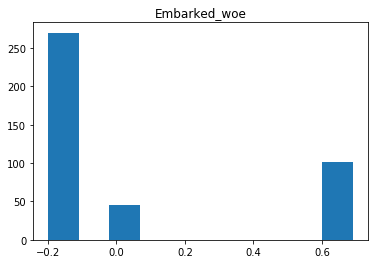

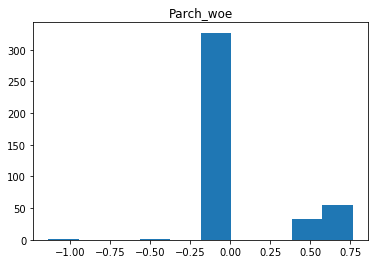

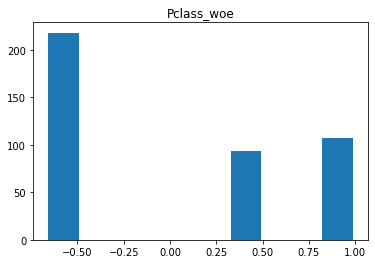

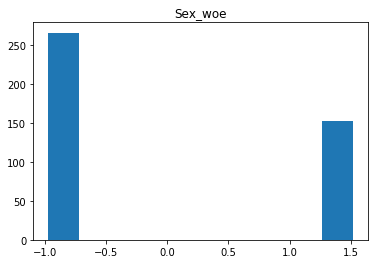

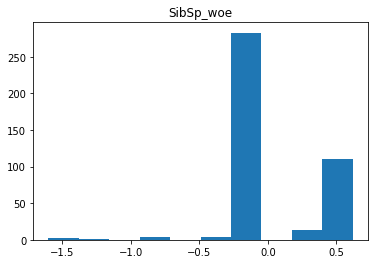

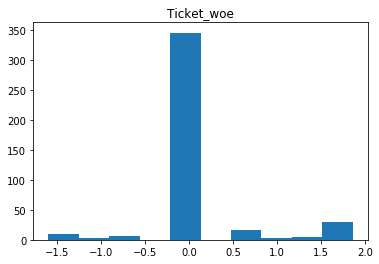

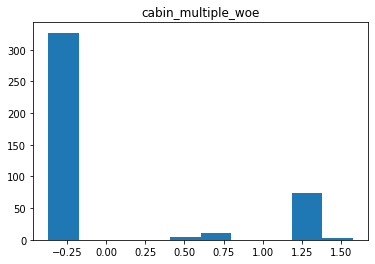

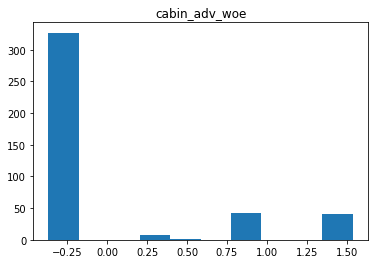

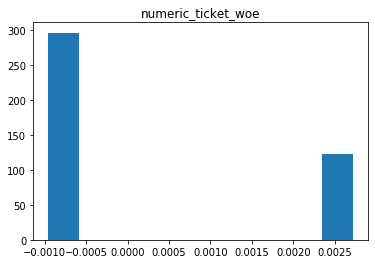

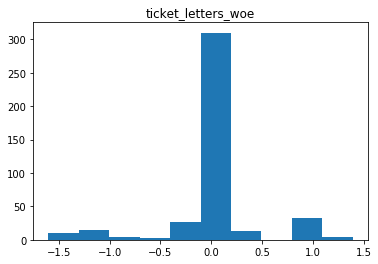

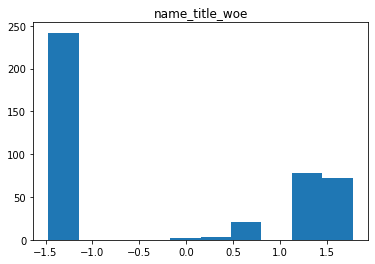

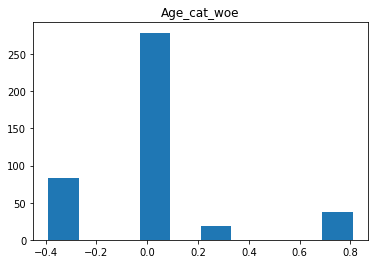

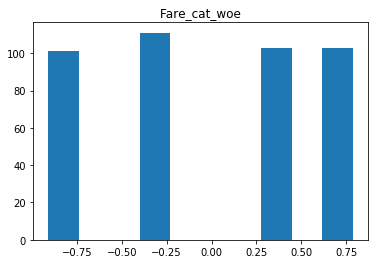

In [37]:
for i in X_train_woe.columns:
    plt.hist(X_test_woe[i])
    plt.title(i)
    plt.show()

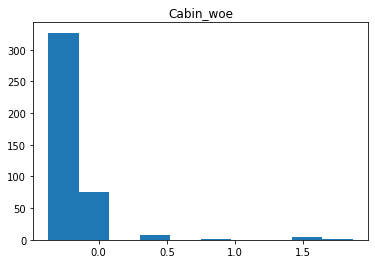

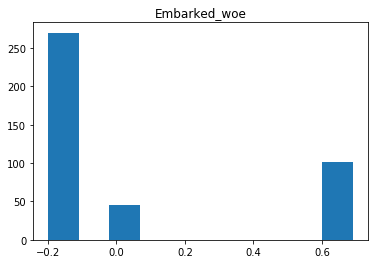

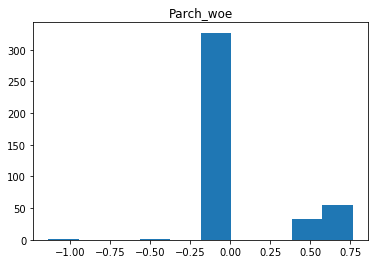

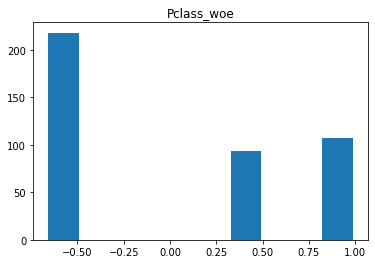

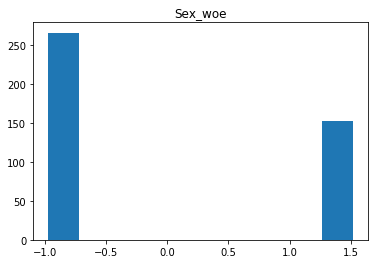

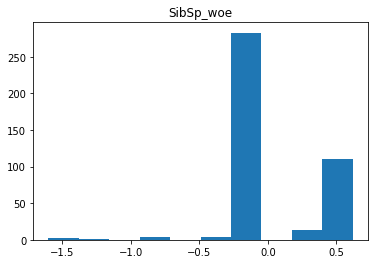

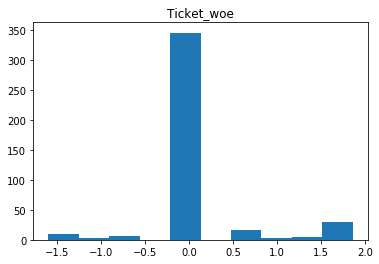

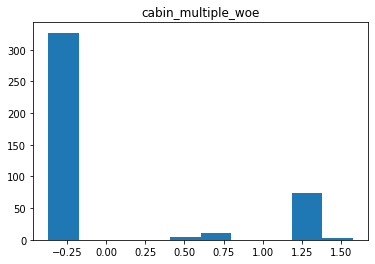

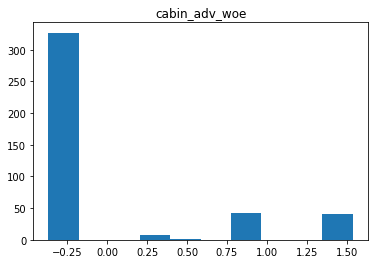

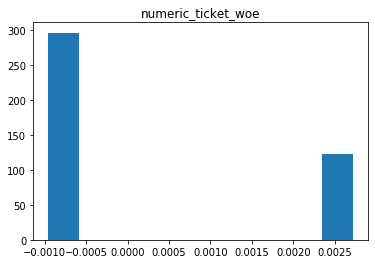

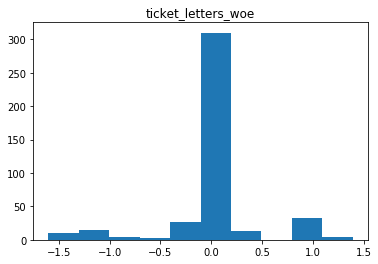

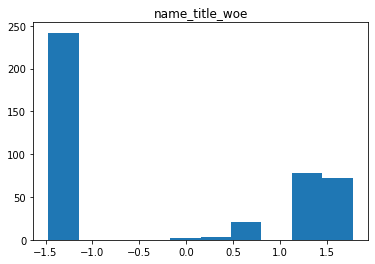

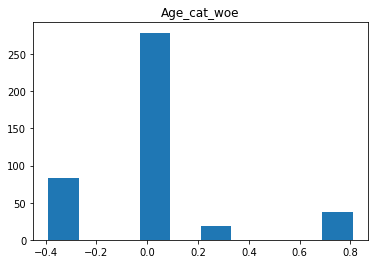

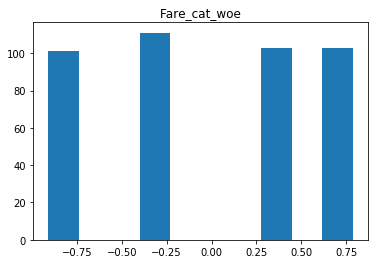

In [38]:
for i in X_test_woe.columns:
    plt.hist(X_test_woe[i])
    plt.title(i)
    plt.show()
 

In [79]:
#Extract the "Survived" column from the all_data dataset in order to get the dependent variable. 

y_train = all_data[all_data.train_test==1].Survived
y_test = all_data[all_data.train_test==0].Survived
y_train.shape

(889,)

## Model Building (Baseline Validation Performance)¶
Before going further, I like to see how various different models perform with default parameters. I tried the following models using 5 fold cross validation to get a baseline. With a validation set baseline, we can see how much tuning improves each of the models. Just because a model has a high basline on this validation set doesn't mean that it will actually do better on the eventual test set.
 
* Naive Bayes (78.30%)
* Logistic regression (86.73%)
* Decision tree (85.83%)
* K nearest neighbor (86.39%)
* Random forest (86.17%)
* Support vector classifier (87.40%)
* Ada boost classifier (87.29%)
* Gradient boosting classifier (88.08%)
* Soft voting classifier - all models (87.52%)

In [40]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [41]:
#I usually use Naive Bayes as a baseline for my classification tasks 
gnb = GaussianNB()
cv = cross_val_score(gnb,X_train_woe,y_train,cv=5)
print(cv)
print(cv.mean())

[0.71910112 0.76966292 0.79775281 0.78089888 0.84745763]
0.7829746714911445


In [42]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X_train_woe,y_train,cv=5)
print(cv)
print(cv.mean())

C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.88764045 0.83146067 0.84831461 0.87078652 0.89830508]
0.8673014663873548


C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [43]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,X_train_woe,y_train,cv=5)
print(cv)
print(cv.mean())

[0.87640449 0.80337079 0.88764045 0.8258427  0.89830508]
0.858312702342411


In [44]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train_woe,y_train,cv=5)
print(cv)
print(cv.mean())

[0.86516854 0.8258427  0.88764045 0.83707865 0.9039548 ]
0.8639370278677078


In [45]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_train_woe,y_train,cv=5)
print(cv)
print(cv.mean())

[0.87078652 0.79213483 0.89325843 0.84831461 0.9039548 ]
0.8616898368564717


C:\Users\i5\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

In [46]:
svc = SVC(probability = True)
cv = cross_val_score(svc,X_train_woe,y_train,cv=5)
print(cv)
print(cv.mean())

C:\Users\i5\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0.8988764  0.85393258 0.86516854 0.85955056 0.89265537]
0.8740366914238556


C:\Users\i5\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [47]:
abc = AdaBoostClassifier()
# n_estimators = 50 (default value)
# base_estimator = DecisionTreeClassifier (default value)
cv = cross_val_score(abc,X_train_woe,y_train,cv=5)
print(cv)
print(cv.mean())

[0.88764045 0.84269663 0.86516854 0.86516854 0.9039548 ]
0.8729257919126516


In [48]:
gbc = GradientBoostingClassifier()
# n_estimators = 100 (default)
# loss function = deviance(default) used in Logistic Regression
cv = cross_val_score(gbc,X_train_woe,y_train,cv=5)
print(cv)
print(cv.mean())

[0.90449438 0.86516854 0.85393258 0.87640449 0.9039548 ]
0.8807909604519774


In [49]:
#Voting classifier takes all of the inputs and averages the results. For a "hard" voting classifier each classifier gets 1 vote "yes" or "no" and the result is just a popular vote. For this, you generally want odd numbers
#A "soft" classifier averages the confidence of each of the models. If a the average confidence is > 50% that it is a 1 it will be counted as such
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('svc',svc),('abc',abc),('gbc',gbc)], voting = 'soft') 

In [50]:
cv = cross_val_score(voting_clf,X_train_woe,y_train,cv=5)
print(cv)
print(cv.mean())

C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\ensemble\fores

[0.88202247 0.85393258 0.85955056 0.87078652 0.90960452]
0.8751793309210945


In [51]:
voting_clf.fit(X_train_woe,y_train)
y_hat_base_vc = voting_clf.predict(X_test_woe).astype(int)
basic_submission = {'PassengerId': test.PassengerId, 'Survived': y_hat_base_vc}
base_submission = pd.DataFrame(data=basic_submission)
base_submission.to_csv('base_submission.csv', index=False)

C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## Model Tuned Performance
After getting the baselines, let's see if we can improve on the indivdual model results!I mainly used grid search to tune the models. I also used Randomized Search for the Random Forest and the boosted models to simplify testing time.

| Model | Baseline | Tuned Performance |
| --- | --- | --- |
| Naive Bayes | 72.30% | NA|
| Logistic regression | 86.73% | 86.95% |
| Decision tree |85.83% | NA |
| K nearest neighbor | 86.39% | 87.30% |
| Random forest | 86.17% | 88.20% |
| Support vector classifier | 87.40% | 88.64% |
| Ada boost classifier | 87.29% | 87.06% |
| Gradient boosting classifier| 88.08% | 88.08%  |

In [52]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

In [53]:
#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [54]:
#Attempted to use regularization, but the results were worse than initially. Henceforth, the 
#default logistic regression without tuning is to be used as a part of the ensemble models.

lr2 = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1','l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['saga']}

clf_lr = GridSearchCV(lr2, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_train_woe,y_train)
clf_performance(best_clf_lr,'Logistic Regression')

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   17.4s


Logistic Regression
Best Score: 0.8695163104611924
Best Parameters: {'C': 0.08858667904100823, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'saga'}


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   27.2s finished


In [55]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X_train_woe,y_train)
clf_performance(best_clf_knn,'KNN')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits
KNN
Best Score: 0.8728908886389202
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 9, 'p': 2, 'weights': 'distance'}


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    1.3s finished


In [56]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train_woe,y_train)
clf_performance(best_clf_svc,'SVC')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 268 out of 275 | elapsed:   45.7s remaining:    1.1s


SVC
Best Score: 0.8863892013498312
Best Parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed:  2.9min finished


In [57]:
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [400,450,500,550],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [15, 20, 25],
                                  'max_features': ['auto','sqrt', 10],
                                  'min_samples_leaf': [2,3],
                                  'min_samples_split': [2,3]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train_woe,y_train)
clf_performance(best_clf_rf,'Random Forest')

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  8.2min finished


Random Forest
Best Score: 0.8818897637795275
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}


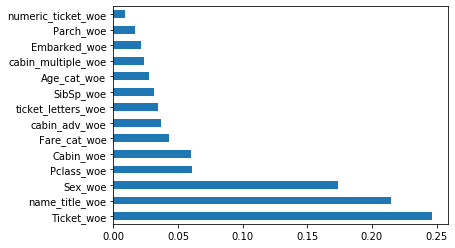

In [58]:
best_rf = best_clf_rf.best_estimator_.fit(X_train_woe,y_train)
feat_importances = pd.Series(best_rf.feature_importances_, index=X_train_woe.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [59]:
param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [100, 200, 300, 400, 500, 600, 1000],
              "learning_rate": [0.001, 0.00075, 0.0005, 0.00025, 0.00001]
             }


RFC = tree.DecisionTreeClassifier(random_state = 1, max_features = "auto", class_weight = "balanced",max_depth = None)
abc = AdaBoostClassifier(base_estimator = RFC)

# run grid search
clf_abc = GridSearchCV(abc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_abc = clf_abc.fit(X_train_woe,y_train)
clf_performance(best_clf_abc,'Ada Boost Classifier')

Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:  7.2min finished


Ada Boost Classifier
Best Score: 0.8717660292463442
Best Parameters: {'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'learning_rate': 0.001, 'n_estimators': 100}


In [60]:
param_grid = {"max_depth": [5, 6, 10, 15],
              "n_estimators": [32, 100],
              "learning_rate": [0.01, 0.001],
              "max_features": [2, 4, 6, 8, 10]
             }

gbc_tuned = GradientBoostingClassifier()

# run grid search
clf_gbc = GridSearchCV(gbc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_gbc = clf_gbc.fit(X_train_woe,y_train)
clf_performance(best_clf_gbc,'Gradient Boosting Classifier')

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.2min finished


Gradient Boosting Classifier
Best Score: 0.8818897637795275
Best Parameters: {'learning_rate': 0.01, 'max_depth': 6, 'max_features': 4, 'n_estimators': 100}


After hyperparameter tuning, the random forest performed the best followed by the gradient boosting classifier.

In [61]:
y_hat_svc = best_clf_svc.best_estimator_.predict(X_test_woe).astype(int)
svc_submission = {'PassengerId': test.PassengerId, 'Survived': y_hat_svc}
submission_svc = pd.DataFrame(data=svc_submission)
submission_svc.to_csv('rf_submission3.csv', index=False)

Model Additional Ensemble Approaches¶
1.  Experimented with a hard voting classifier of three estimators (KNN, SVC, RF) (88.42%)

2.  Experimented with a soft voting classifier of three estimators (KNN, SVC, RF) (87.97%) 

3.  Experimented with soft voting on all 6 estimators (KNN, RF, LR, SVC, ABC, GBC) (88.30%)

4.  Experimented with soft voting on all estimators excludinc ABC (KNN, SVC, RF, LR, GBC) (88.87%)(Best Performance)

In [62]:
best_lr = best_clf_lr.best_estimator_
best_knn = best_clf_knn.best_estimator_
best_svc = best_clf_svc.best_estimator_
best_rf = best_clf_rf.best_estimator_
best_abc = best_clf_abc.best_estimator_
best_gbc = best_clf_gbc.best_estimator_

voting_clf_hard = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc)], voting = 'hard') 
voting_clf_soft = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc)], voting = 'soft') 
voting_clf_all = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc), ('lr', best_lr),('abc',best_abc), ('gbc', best_gbc)], voting = 'soft') 
voting_clf_best = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc), ('lr', best_lr), ('gbc', best_gbc)], voting = 'soft') 

print('voting_clf_hard :',cross_val_score(voting_clf_hard,X_train_woe,y_train,cv=5))
print('voting_clf_hard mean :',cross_val_score(voting_clf_hard,X_train_woe,y_train,cv=5).mean())

print('voting_clf_soft :',cross_val_score(voting_clf_soft,X_train_woe,y_train,cv=5))
print('voting_clf_soft mean :',cross_val_score(voting_clf_soft,X_train_woe,y_train,cv=5).mean())

print('voting_clf_all :',cross_val_score(voting_clf_all,X_train_woe,y_train,cv=5))
print('voting_clf_all mean :',cross_val_score(voting_clf_all,X_train_woe,y_train,cv=5).mean())

print('voting_clf_best :',cross_val_score(voting_clf_best,X_train_woe,y_train,cv=5))
print('voting_clf_best mean :',cross_val_score(voting_clf_best,X_train_woe,y_train,cv=5).mean())

voting_clf_hard : [0.88764045 0.84831461 0.89325843 0.88202247 0.90960452]
voting_clf_hard mean : 0.8841680949660382
voting_clf_soft : [0.89325843 0.84269663 0.87078652 0.87640449 0.90960452]
voting_clf_soft mean : 0.8785501174379483
voting_clf_all : [0.90449438 0.84831461 0.86516854 0.88202247 0.90960452]
voting_clf_all mean : 0.8830444994604203
voting_clf_best : [0.90449438 0.86516854 0.87640449 0.88202247 0.91525424]
voting_clf_best mean : 0.8886688249857171


In [63]:
#in a soft voting classifier you can weight some models more than others. I used a grid search to explore different weightings
#no new results here
params = {'weights' : [[1,3,2,1,1],[1,3,2,1,2],[1,3,2,1,3],[1,4,2,1,3],[1,1,1,1,1],[1,4,3,1,2],[1,2,1,1,2],[0.2,0.2,0.2,0.2,0.2]]}

vote_weight = GridSearchCV(voting_clf_best, param_grid = params, cv = 5, verbose = True, n_jobs = -1)
best_clf_weight = vote_weight.fit(X_train_woe,y_train)
clf_performance(best_clf_weight,'VC Weights')
voting_clf_sub = best_clf_weight.best_estimator_.predict(X_train_woe)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   24.9s finished


VC Weights
Best Score: 0.8886389201349831
Best Parameters: {'weights': [1, 1, 1, 1, 1]}


In [64]:
#Make Predictions 
voting_clf_hard.fit(X_train_woe, y_train)
voting_clf_soft.fit(X_train_woe, y_train)
voting_clf_all.fit(X_train_woe, y_train)
voting_clf_best.fit(X_train_woe, y_train)

best_svc.fit(X_train_woe, y_train)
y_hat_vc_hard = voting_clf_hard.predict(X_test_woe).astype(int)
y_hat_rf = best_rf.predict(X_test_woe).astype(int)
y_hat_vc_soft =  voting_clf_soft.predict(X_test_woe).astype(int)
y_hat_vc_all = voting_clf_all.predict(X_test_woe).astype(int)
y_hat_vc_best = voting_clf_best.predict(X_test_woe).astype(int)

In [65]:
#convert output to dataframe 
final_data = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_hard}
submission = pd.DataFrame(data=final_data)

final_data_2 = {'PassengerId': test.PassengerId, 'Survived': y_hat_svc}
submission_2 = pd.DataFrame(data=final_data_2)

final_data_3 = {'PassengerId': test.PassengerId, 'Survived':y_hat_vc_soft}
submission_3 = pd.DataFrame(data=final_data_2)

final_data_4 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_all}
submission_4 = pd.DataFrame(data=final_data_3)

final_data_5 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_best}
submission_5 = pd.DataFrame(data=final_data_5)

final_data_comp = {'PassengerId': test.PassengerId, 'Survived_vc_hard': y_hat_vc_hard, 'Survived_svc': y_hat_svc, 'Survived_vc_soft' : y_hat_vc_soft, 'Survived_vc_all' : y_hat_vc_all,  'Survived_vc_best' : y_hat_vc_best}
comparison = pd.DataFrame(data=final_data_comp)

In [66]:
#track differences between outputs 
comparison['difference_svc_vc_hard'] = comparison.apply(lambda x: 1 if x.Survived_vc_hard != x.Survived_svc else 0, axis =1)
comparison['difference_soft_hard'] = comparison.apply(lambda x: 1 if x.Survived_vc_hard != x.Survived_vc_soft else 0, axis =1)
comparison['difference_hard_all'] = comparison.apply(lambda x: 1 if x.Survived_vc_all != x.Survived_vc_hard else 0, axis =1)

In [67]:
comparison.difference_hard_all.value_counts()

0    391
1     27
Name: difference_hard_all, dtype: int64

In [68]:
#prepare submission files 
submission.to_csv('submission_vc_hard.csv',index=False)
submission_2.to_csv('submission_svc.csv', index=False)
submission_3.to_csv('submission_vc_soft.csv', index=False)
submission_4.to_csv('submission_vc_all.csv', index=False)
submission_5.to_csv('submission_vc_best.csv', index =False)

## Conclusion

The soft voting classifier on 5 estimators (KNN, SVC, RF, LR, GBC) had the best performance; with a score of 88.87%. 